1\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn!):

* Fill a numpy array, x,  of len(N) (with N=O(100)) with a variable normally distributed, with a given mean a standard deviation
* Fill an histogram in pyplot taking properly care about the aesthetic
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* for every element of x, create a gaussian with the mean corresponding the element value and std as a parameter that can be tuned. The std default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5.}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with np.sum()) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, MultipleLocator, FuncFormatter
from matplotlib import cm as colormap
import seaborn as sns
from scipy import stats
import pandas as pd
%matplotlib inline


Printing y:

 (array([ 1.,  1.,  5.,  4., 22., 32., 39., 29., 27., 24., 11.,  4.,  1.,
        0.,  0.]), array([-3.5, -3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,
        2. ,  2.5,  3. ,  3.5,  4. ]), <a list of 15 Patch objects>) 



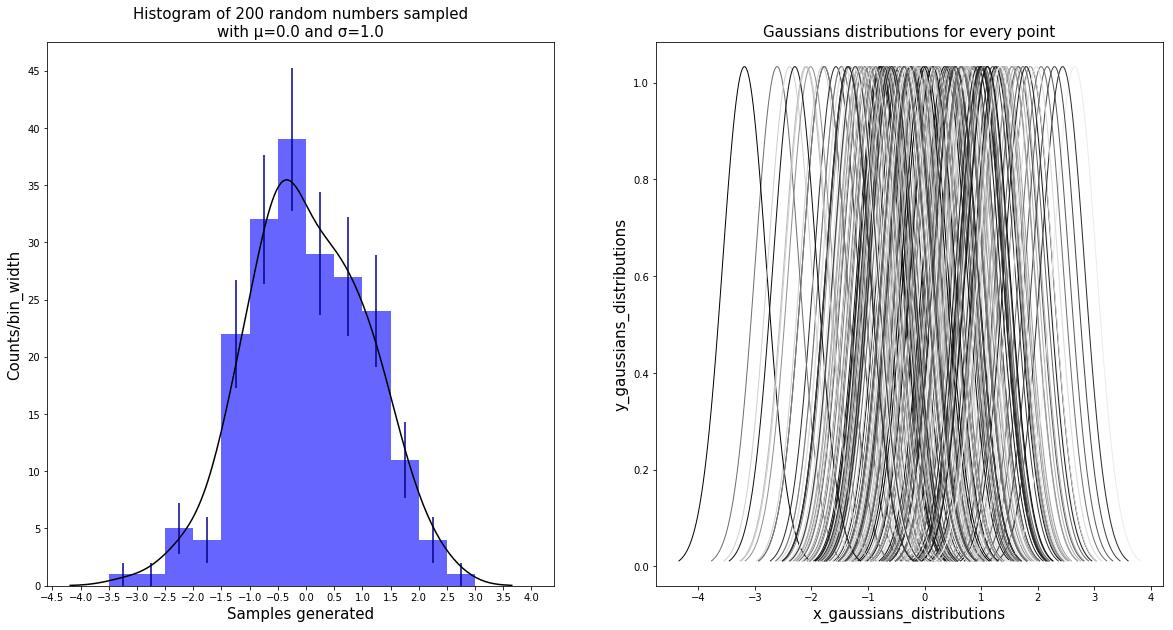

In [2]:
# fixing mean and std
mean_, std_ = 0., 1.
N = 200
x = np.random.normal(mean_, std_, N)

fig, (ax1, ax2) = plt.subplots ( nrows = 1, ncols = 2  , figsize = (20, 10))

width = int(std_)/2.

#ax.hist(x, bins=np.arange( -4*std_+mean_, 4*std_+mean_+1, int(round(std_/(N/100.)+1))), label='x')

# using arbitrary intervals: they should be re-analized and fixed if used outside this exercise
y = (ax1.hist(x, bins=np.arange( -3.5*std_+mean_, 3.5*std_+mean_+1, width) , label='x'))
#ax1.set_ylabel(('Counts/'+str(std_/(N/100.))))
#ax1.set_ylabel('Counts/bin_width with bin_width = '+str(std_/(N/100.)))
ax1.set_ylabel('Counts/bin_width', fontsize=15)
ax1.set_xlabel("Samples generated", fontsize=15)
ax1.set_title("Histogram of " + str(N) + " random numbers sampled" + "\n" "with μ=" + str(mean_) + " and σ=" + str(std_), fontsize=15)
#ax1.xaxis.set_major_locator(MultipleLocator(int(round(std_/(N/1.)+1))))
# also these are arbitrary values: if one wants to re-use these functions then they have to be modofied
ax1.xaxis.set_major_locator(MultipleLocator(width))
ax1.yaxis.set_major_locator(MultipleLocator(int(5*std_)))    # FWHM = 2.355*std

# printing y to check its values
print("\nPrinting y:\n\n", y, "\n")

# Evaluating mean of bin borders to get the central value
x_coord = 0.5*(y[1][1:] + y[1][:-1])

# Evaluating square roots to get the bin error
bin_stds = np.sqrt(y[0])

ax1.bar(x_coord, y[0], width=width, yerr = bin_stds, ecolor = "#000088", color="#6666ff")

std_x_ = 1.06*x.std()*(x.size**(-0.2))


ax2.set_title("Gaussians distributions for every point", fontsize=15)
ax2.set_ylabel("y_gaussians_distributions", fontsize=15)
ax2.set_xlabel("x_gaussians_distributions", fontsize=15)

# Trying color modulation
col_min = 0x000000     # 0x000000 (r = 00,       g = 00,       b = 00) = black
col_max = 0xff00ff     # 0xffff00 (r = ff (max), g = ff (max), b = 00) = yellow

#for val in x:
#    interv = np.linspace(val-3*std_x_, val+3*std_x_, 100)
#    ax2.plot(interv, stats.norm.pdf(interv, loc=val , scale=std_x_), 'k', lw = 1)

for cont in range(len(x)):
    interv = np.linspace(x[cont]-3*std_x_, x[cont]+3*std_x_, 100)
    color_ = (col_min + cont/float(len(x))*col_max)
    color_ = (str(color_)).replace('0x', '#')
    ax2.plot(interv, stats.norm.pdf(interv, loc=x[cont] , scale=std_x_), color = color_ , lw = 1)



x_to_sums = np.linspace( -1+x.min(), x.max()+1, N )

#for x_val in x_to_sums:
#    ax1.plot(x_val, np.sum([x_gaussians(x, loc=x_val , scale=std_x_)])*width, 'ko')


y_KDE = x_to_sums.copy()

for cont in range(len(y_KDE)):
    y_KDE[cont] = np.sum(stats.norm.pdf(x, loc=x_to_sums[cont] , scale=std_x_))*width

ax1.plot(x_to_sums, y_KDE, 'k-')

# RINORMALIZZARE RISPETTO AL BINNING

/home/tommaso/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


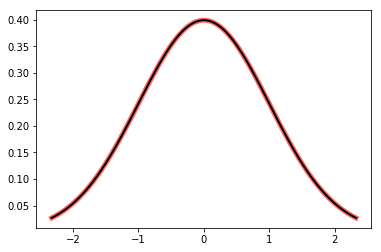

In [3]:
fig, ax = plt.subplots(1, 1)

x = np.linspace(stats.norm.ppf(0.01), stats.norm.ppf(0.99), 100)
ax.plot(x, stats.norm.pdf(x), 'r-', lw=5, alpha=0.6, label='norm pdf')

rv = stats.norm()
ax.plot(x, rv.pdf(x), 'k-', lw=2, label='frozen pdf')

fig.show()

2\. **Color-coded scatter plot**

Produce a scatter plot out of a dataset with two categories

* Write a function that generate a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and std (clearly it is better to have different values means..)
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below

You can try to make the procedure more general by allowing a given number $n\ge 2$ of categories

--2018-12-03 23:41:00--  https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
Risoluzione di www.dropbox.com (www.dropbox.com)... 162.125.69.1, 2620:100:6025:1::a27d:4501
Connessione a www.dropbox.com (www.dropbox.com)|162.125.69.1|:443... connesso.
Richiesta HTTP inviata, in attesa di risposta... 301 Moved Permanently
Posizione: /s/raw/u4y3k4kk5tc7j46/two_categories_scatter_plot.png [segue]
--2018-12-03 23:41:03--  https://www.dropbox.com/s/raw/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
Riutilizzo della connessione esistente a www.dropbox.com:443.
Richiesta HTTP inviata, in attesa di risposta... 302 Found
Posizione: https://uc97704c7f21ed8ee8ddaf562f4a.dl.dropboxusercontent.com/cd/0/inline/AWyHxlenma2Ro9ZMHjbtcycJjKGhU4pl1sBMAkWikUBnJ_PAVeLo2NmUu55cdP5mJklelqJalGBaFas0yUex-Pl7etntlsRklCfE53aas3HFjlqRjwZNm7oieXoZEg92t_G6varYosahHXcFB_0v-G6K3EXgz2DVKN08HFRgxgGtGhIRNdz3jhBYLyYb8ewopvk/file [segue]
--2018-12-03 23:41:03--  https://uc97704c7f21ed8ee8ddaf562f4a.dl.

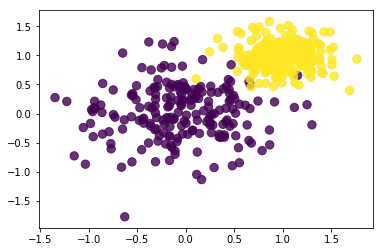

In [6]:
! wget https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
from IPython.display import Image
Image('two_categories_scatter_plot.png')


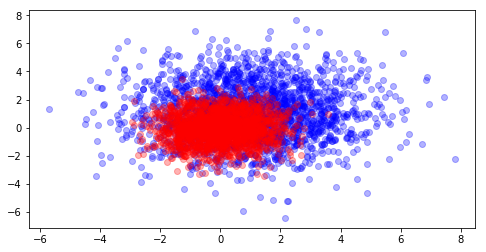

In [8]:
def gen_2D_dataset(mean1 = 0., std1 = 1., mean2 = 0., std2 = 1., N = 100):
    f = np.random.normal                    # Renaming the function to make the code more readable
    data = pd.DataFrame([[[f(mean1, std1), f(mean1, std1)], [f(mean2, std2), f(mean2, std2)]] for i in range(N)], columns=['Serie1', 'Serie2'])
    
    return data

m1, var1, m2, var2 = 1., 2., 0., 1.
Num = 2000
dataset_ = gen_2D_dataset(m1, var1, m2, var2, Num)

#print([dataset_['Serie1'][i][0] for i in range(4)])
x1 = [dataset_['Serie1'][i][0] for i in range(len(dataset_))]
x2 = [dataset_['Serie2'][i][0] for i in range(len(dataset_))]

y1 = [dataset_['Serie1'][i][1] for i in range(len(dataset_))]
y2 = [dataset_['Serie2'][i][1] for i in range(len(dataset_))]


fig, ax = plt.subplots(figsize = (8, 4))
scatter = ax.scatter(x = x1, y = y1, c = 'b', alpha=0.3)
scatter = ax.scatter(x = x2, y = y2, c = 'r', alpha=0.3)


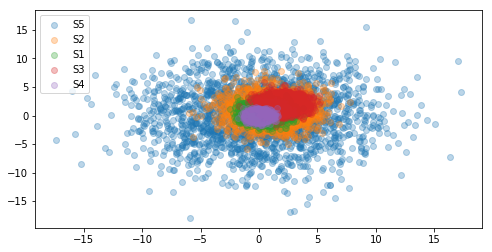

In [12]:
# definying the function that create the gaussians
def gen_nD_gaussian_dataset(mean_array, std_array, labels_array, N = 100):
    if (len(mean_array) != len(std_array) or len(labels_array) != len(mean_array)):
        print("Error while running the function: the arrays of mean, std and labels MUST have the same dimensions.")
        return None
    f = np.random.normal                    # Renaming the function to make the code more readable
    data = pd.DataFrame([[[f(mean_array[i], std_array[i]), f(mean_array[i], std_array[i])] for i in range(len(mean_array))] for i in range(N)], columns=labels_array)
    
    return data

# 
mean = np.array([0.5, 1., 2., 0., 0.])
std = np.array([1., 2., 1., 0.5, 5.])
labels = np.array(['S1', 'S2', 'S3', 'S4', 'S5'])
prova = gen_nD_gaussian_dataset(mean, std, labels, 2000)



# Starting to sort using std: larger sets should be placed in "lower positions" to not overwrite other sets

max_ = std[0]          # Setting a random element as max

std_copy = std.copy()

# copying stuff that then can be modified
mean_sort = mean.copy()
std_sort = std.copy()
labels_sort = labels.copy()

for cont1 in range(len(std)):
    for cont2 in range(len(std)):
        if std_copy[cont2]>max_:
            max_ = std[cont2]
            index_ = cont2
    
    #print(cont1, mean_sort, std_sort, labels_sort, max_)
    
    mean_sort[cont1]   = mean[index_]
    std_sort[cont1]    = std[index_]
    labels_sort[cont1] = labels[index_]
    
    std_copy[index_] = -1.           # Carattere per "eliminare" l'elemento (in questo modo non verrà più considerato nel prossimo sort)
    max_ = -1.

# Ended sorting


# plotting
fig, ax = plt.subplots(figsize = (8, 4))
    

for i in range(len(labels)):
    label = str(labels_sort[i])
    x_v = [prova[label][j][0] for j in range(len(prova))]
    y_v = [prova[label][j][1] for j in range(len(prova))]
    ax.scatter(x = x_v, y = y_v, label = label, alpha=0.3)

plt.legend()
plt.show()

3\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following dataset and load it as a pandas dataframe:
```bash
wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
```
Note that you should use the `np.load()` function to load the file as a numpy array and then pass it to the `pd.DataFrame()` constructor.
* Inspect the dataset, you'll find two variables (features)
* Clean the sample by selecting the entries (rows) with the variable "residual" in absolute value smaller than 2
* perform a linear regression of "residuals" versus "distances" using `scipy.stats.linregress()` 
* plot a seaborn jointplot of  "residuals" versus "distances", having seaborn performing a linear regression. The result of the regression should be displayed on the plot
* Fill 3 numpy arrays
  * x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
  * y, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * erry, the standard deviation of the  of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

In [1]:
!wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy

--2018-12-02 18:51:17--  https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
Risoluzione di www.dropbox.com (www.dropbox.com)... 162.125.69.1, 2620:100:6025:1::a27d:4501
Connessione a www.dropbox.com (www.dropbox.com)|162.125.69.1|:443... connesso.
Richiesta HTTP inviata, in attesa di risposta... 301 Moved Permanently
Posizione: /s/raw/hgnvyj9abatk8g6/residuals_261.npy [segue]
--2018-12-02 18:51:18--  https://www.dropbox.com/s/raw/hgnvyj9abatk8g6/residuals_261.npy
Riutilizzo della connessione esistente a www.dropbox.com:443.
Richiesta HTTP inviata, in attesa di risposta... 302 Found
Posizione: https://uc8bbf95744c4720618173ef110b.dl.dropboxusercontent.com/cd/0/inline/AWtIUsU2DalvEobB3n2YmfFeYc6M1yp8tFEbjwmu2u6Ackw7FSEsD0aLcFJSLTZnCkrouyY2z9zUymqOFZx0F9JC8XM3a5rngJLOsMV5Rda7UrfjklXDd_YNElz6l8ToyrYKSnoVK325L663dGEcxrorid-VjgZGn5qnRcU0kHW71IqhLkQ7L3lx5g8LzhU4WKQ/file [segue]
--2018-12-02 18:51:19--  https://uc8bbf95744c4720618173ef110b.dl.dropboxusercontent.com/cd/0/inline/AWtIUsU

Slope:  0.0032597701220305835 
Intercept:  -0.15432816763069473 
Rvalue:  0.043403510522559086 
pvalue 8.717037183576464e-06 
stderr 0.0007327014008445789
[-0.15444189 -0.14708155 -0.12184946 -0.09086605 -0.06518779 -0.09201687
 -0.13737166 -0.13827136 -0.14168251 -0.03698068]


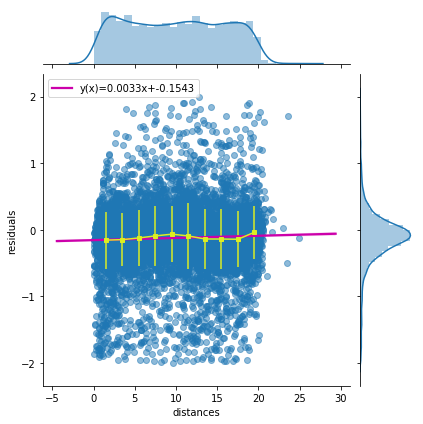

In [25]:
data_array = np.load("residuals_261.npy")

#data_ = pd.DataFrame(data_array.tolist(), columns = ['residuals','distances'])

data_ = pd.DataFrame(data_array.item())

#print(data_)

data_ = data_[np.abs(data_['residuals'])<2]

# collecting informations about the regression
slope, intercept, rvalue, pvalue, stderr = stats.linregress(data_['distances'], data_['residuals'])

print("Slope: ", slope, "\nIntercept: ", intercept, "\nRvalue: ", rvalue, "\npvalue", pvalue, "\nstderr", stderr)

# doing the jointplot
grap = sns.jointplot(data_['distances'], data_['residuals'], kind='reg', scatter_kws={'alpha':0.5}, line_kws={'label':"y(x)={0:.4f}x+{1:.4f}".format(slope, intercept), 'color':'#cc00aa'})
# showing legend on the plot
grap.ax_joint.legend()


# Creating x, y, erry

step_ = 2

x = np.array(0.5 + np.arange(1, 21, step_))

y = x.copy()

#for i in range(len(x)):
#    app = data_[(data_['distances']>(i*step_)) & (data_['distances']<((i+1)*step_))]['residuals']
#    y[i] = app.mean()

# building y as the mean of samples that stay from distance=i to distance=i+step
y = np.array([(np.array([data_[(data_['distances']>=i) & (data_['distances']<(i+step_))]['residuals']])).mean() for i in range(1, 21, step_)])
erry = np.array([(np.array([data_[(data_['distances']>=i) & (data_['distances']<(i+step_))]['residuals']])).std() for i in range(1, 21, step_)])
print(y)

plt.errorbar(x, y, yerr=erry, color="#ddee22", marker = 's', markersize = 4.)
plt.show()